## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats as sts
from scipy.optimize import minimize


import math
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.optimize as opt
import os
import quandl as qdl
import pandas_datareader as pdr
import scipy.optimize as opt
import sympy 
from sympy import *


In [2]:
Data_AAPL=qdl.get("WIKI/AAPL", start_date="2014-12-01", end_date="2017-12-31", api_key="rEz1z79b7pWuy8vexQjX")
Data_BTC= qdl.get("RICI/RICIA", start_date="2014-12-01", end_date="2017-12-31", api_key="rEz1z79b7pWuy8vexQjX")
Data_EUR= qdl.get("CUR/EUR", start_date="2014-12-01", end_date="2017-12-31", api_key="rEz1z79b7pWuy8vexQjX")

Number_Data = len(Data_AAPL)

Data_Model = np.log10(Data_AAPL['Adj. Close'])

Data_AAPL['log_value'] = np.log10(Data_AAPL['Adj. Close'])
Data_AAPL['log10_value'] = np.log10(Data_AAPL['Adj. Close'])

data0 = Data_AAPL.copy()
data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

AAPL=data0.copy()


#data0['Adj. Close'].plot()   Data_AAPL['Adj. Close'].plot() Data_EUR['RATE'].plot() Data_BTC['Bid'].plot() 
#Number_Days = Data_AAPL.count(9)


In [418]:
Data_AAPL['log_value'] .to_excel("Data_AAPL.xlsx")

## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

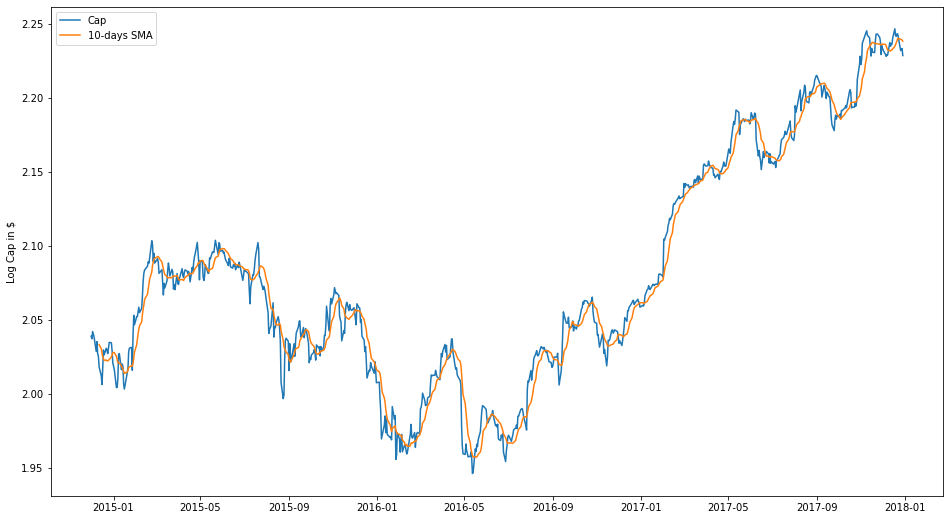

In [30]:
# Calculating the short-window (10 days) simple moving average
start_date = '2014-12-01'
end_date = '2017-12-31'


window_1 = 10
short_rolling = Data_AAPL.rolling(window=window_1).mean()
short_rolling_apple=pd.DataFrame(short_rolling.loc[start_date:end_date, 'log_value'])
Number_Days = len(short_rolling_apple)
ticker = 'AAPL'

apple= pd.DataFrame(Data_AAPL.loc[start_date:end_date, 'log_value'])
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

ax.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Cap')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'log_value'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Log Cap in $')

plt.show()

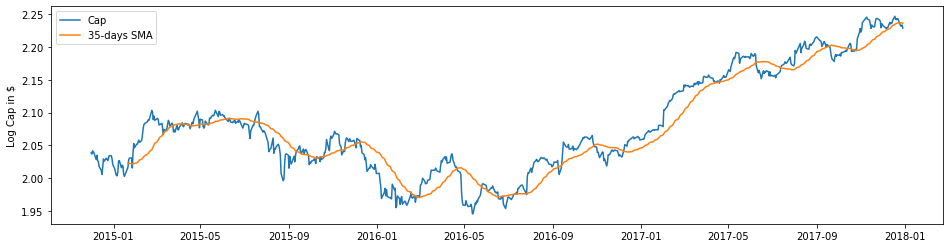

In [5]:
# Calculating the long-window (30 days) simple moving average

start_date = '2014-12-01'
end_date = '2017-12-31'


window_2 = 35
long_rolling = Data_AAPL.rolling(window=window_2).mean()
long_rolling_apple=pd.DataFrame(long_rolling.loc[start_date:end_date, 'log_value'])
ticker = 'AAPL'

apple = pd.DataFrame(Data_AAPL.loc[start_date:end_date, 'log_value'])
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Cap')
ax.plot(long_rolling_apple.loc[start_date:end_date, :].index,long_rolling_apple.loc[start_date:end_date, 'log_value'], 
         label = '%d-days SMA' % window_2)

ax.legend(loc='best')
ax.set_ylabel('Log Cap in $')

plt.show()
# long_rolling.tail()

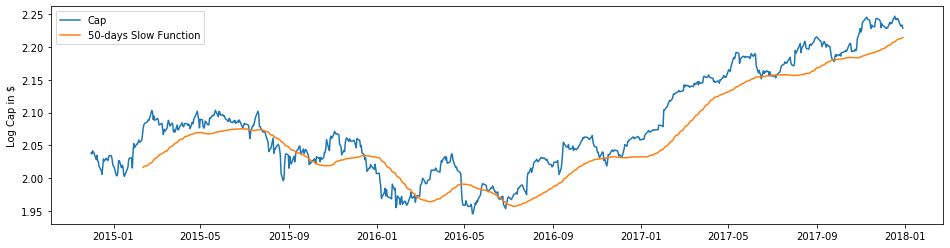

In [6]:
# Calculating the slowly function (50 days) simple moving average

start_date = '2014-12-01'
end_date = '2017-12-31'

Beta_WM = np.log (2.7)

window_3 = 50
slow_function = Data_AAPL.rolling(window=window_3).mean()*Beta_WM
slow_function_apple=pd.DataFrame(slow_function.loc[start_date:end_date, 'log_value'])
ticker = 'AAPL'

apple= pd.DataFrame(Data_AAPL.loc[start_date:end_date, 'log_value'])

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Cap')
ax.plot(slow_function.loc[start_date:end_date, :].index, slow_function.loc[start_date:end_date, 'log_value'], 
         label = '%d-days Slow Function' % window_3)

ax.legend(loc='best')
ax.set_ylabel('Log Cap in $')

plt.show()
# long_rolling.tail()

### Plot three years of AAPL stock:

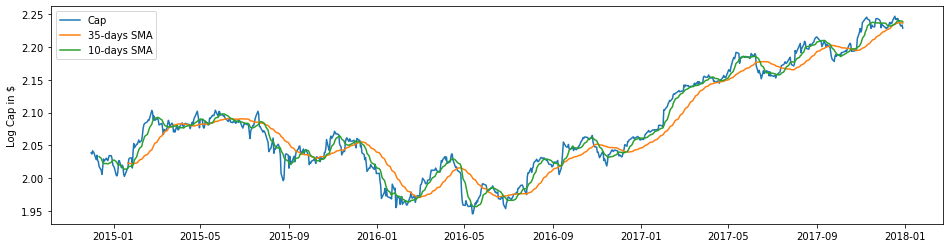

In [7]:
ticker = 'AAPL'
start_date = '2014-12-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Cap')
ax.plot(long_rolling_apple.loc[start_date:end_date, :].index, long_rolling_apple.loc[start_date:end_date, 'log_value'], 
          label = '%d-days SMA' % window_2)

ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'log_value'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Log Cap in $')

plt.show()

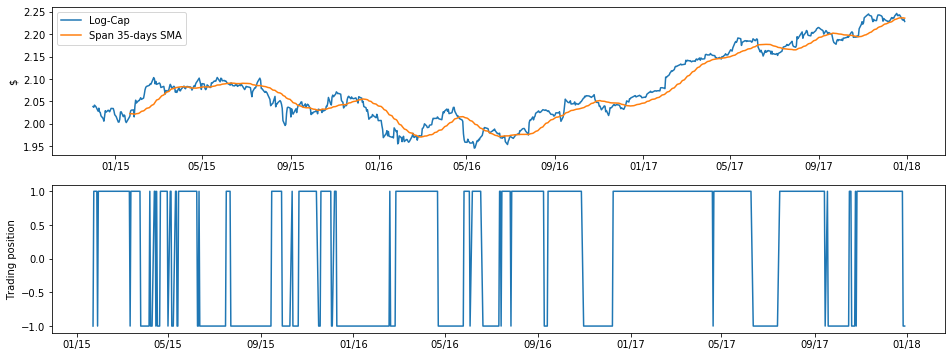

In [8]:
# Trading Position & Time Series simulation
trading_positions_raw_apple = apple - long_rolling_apple
trading_positions_raw_apple.tail()
trading_positions_apple = trading_positions_raw_apple.apply(np.sign) * 1
trading_positions_final_apple = trading_positions_apple.shift(1)
trading_positions_final_apple.tail()
TRADE_LT = trading_positions_final_apple.loc[start_date:end_date, 'log_value']
#Trade_SR=trading_positions_final_apple.loc[start_date:end_date, 'log_value']

import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')
fig, (yx1, yx2) = plt.subplots(2, 1, figsize=(16,6))



yx1.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Log-Cap')
yx1.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'log_value'], label = 'Span 35-days SMA')

yx1.set_ylabel('$')
yx1.legend(loc='best')
yx1.xaxis.set_major_formatter(my_year_month_fmt)

yx2.plot(trading_positions_final_apple.loc[start_date:end_date, :].index, trading_positions_final_apple.loc[start_date:end_date, 'log_value'], 
        label='Trading position')

yx2.set_ylabel('Trading position')
yx2.xaxis.set_major_formatter(my_year_month_fmt)

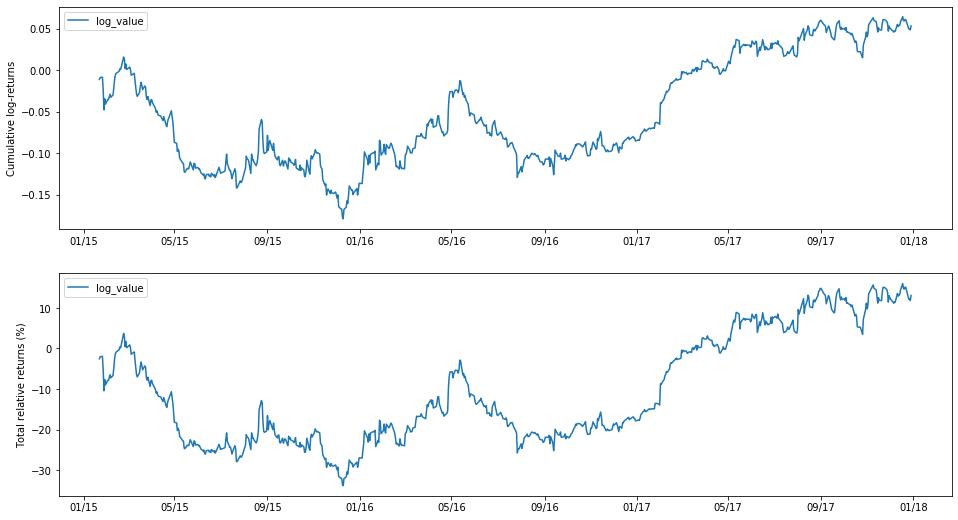

In [9]:

asset_log_returns_apple = apple.diff()
asset_log_returns_apple .head()
strategy_asset_log_returns_apple = asset_log_returns_apple * trading_positions_final_apple 
strategy_asset_log_returns_apple.tail()


# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns_apple = strategy_asset_log_returns_apple.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns_apple = 10**(cum_strategy_asset_log_returns_apple) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns_apple:
    ax1.plot(cum_strategy_asset_log_returns_apple.index, cum_strategy_asset_log_returns_apple[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)


for c in asset_log_returns_apple:
    ax2.plot(cum_strategy_asset_relative_returns_apple.index, 100*cum_strategy_asset_relative_returns_apple[c], label=str(c))
    risk_f = 100*cum_strategy_asset_relative_returns_apple[c]
    
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [10]:
#The overall, yearly, performance of our strategy can be calculated again as:
cum_strategy_asset_relative_returns_apple_long = 10**(cum_strategy_asset_relative_returns_apple) - 1
cum_relative_return_exact_apple_long = cum_strategy_asset_relative_returns_apple_long.sum(axis=1)

def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns_apple_long, days_per_year = 52 * 3):

    total_days_in_simulation_long = portfolio_cumulative_relative_returns_apple_long.shape[0]
    number_of_years = total_days_in_simulation_long / days_per_year

    # The last data point will give us the total portfolio return
    
    total_portfolio_return_apple_long = portfolio_cumulative_relative_returns_apple_long[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return_apple_long = (1 + total_portfolio_return_apple_long)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return_apple_long) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return_apple_long) + '%')
    Avg_yearly = 100*average_yearly_return_apple_long
    return Avg_yearly
#print_portfolio_yearly_statistics(cum_relative_return_exact_apple_long)
Avg_yearly=print_portfolio_yearly_statistics(cum_relative_return_exact_apple_long)

Total portfolio return is: 35.04%
Average yearly return is:  6.23%


## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


## Part 1.B: Evaluation Langevin equation

$$
\; \; \; V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

$$
\frac{ \partial V(y)}{\partial y}\equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right)   + \kappa e^y +  g e^{2y}
$$

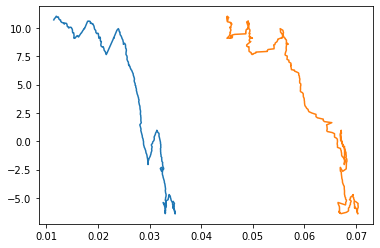

In [11]:
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from pylab import *


rf = pd.DataFrame(risk_f/100)

AAPL_Sigma = (Data_AAPL['log_value'] / Data_AAPL['log_value'].shift(1))
sigma_1 = AAPL_Sigma.rolling(window=365).std() * np.sqrt(365)

sigma = pd.DataFrame(sigma_1)*1

c = pd.DataFrame(np.linspace(.021,.065, num=Number_Days) / Data_AAPL['log_value'] )



mu_d = (np.linspace(-np.pi/10, np.pi/2.35, num=Number_Days, endpoint=True))
phi = pd.DataFrame(TRADE_LT)
mu_c =  np.cos(mu_d)
mu_d = pd.DataFrame(np.cos(mu_d))
mu_1 = pd.DataFrame((mu_c) *Data_AAPL['log_value'] )/100
#mu_1 .plot()
lamda = slow_function_apple
g     = (mu_1  * lamda)

k_1 = (mu_1 *phi).cumsum()

k     =( k_1 - lamda/2.25) # 2.25 its only for adjust value to 1

#cum_strategy_asset_log_returns_apple.plot()
#phi.plot()
vv= (rf)
#vv.plot()
Theta= ((vv -0.0017+ phi).cumsum())/100
#Theta.plot()
#sigma.plot()
#g.plot()
#k.plot()
#pl.plot(k)
#pl.plot(mu_1)   - ((Theta)-(sigma**2/2))+k*np.exp(apple)+g*np.exp(2*apple)

V_n =  (- ((Theta)-(sigma**2/2))+k*np.exp(apple)+g*np.exp(2*apple))

#apple.plot()
#phi.plot()
#vv.plot()
#mu_1 .plot()
#g.plot()
#k.plot()
#V_n.plot()

pl.plot(g,V_n)
pl.plot(sigma,V_n)

#pl.show()

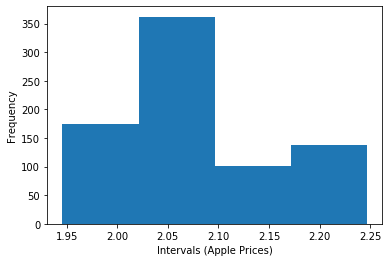

In [12]:
#Histogram of Data Points

data = Data_AAPL['log_value']
leng = len (data)
  
# First quartile (Q1) 
n=len (data)
Range = max(data)-min(data)
N_Interval = np.sqrt(n)

Bin_Size_M = Range / N_Interval
Dec, Integer = math.modf(Bin_Size_M)
Bin_Size = int(Integer )


# This next command is specifically for Jupyter Notebook
#%matplotlib notebook




num_bins = Bin_Size + 4
#plt.style.use('ggplot')
plt.hist(data, bins = num_bins)
plt.xlabel('Intervals (Apple Prices)')
plt.ylabel('Frequency')
plt.show()  # This gives the xmin and xmax to be plotted"

In [14]:
#MLE FOR EQUATION

def trunc_norm_pdf(Y_t,R_year_crit, Theta_crit ,sigma_crit,k_crit,g_crit,w_crit,Z_crit):
    

  #Parameter of the Model
    Theta_par = Theta_crit #params_norm[0]
    sigma_par = sigma_crit #params_norm[1]np.array([1.3, 0.7, 0.8, 1.9, 1.2])
    k_1_par = k_crit #params_norm[2]
    g_1_par =g_crit #params_norm[3]
    W_1_par =w_crit
    
    #Arguments & Signals of the Model
    Zt_norm=Z_crit
    Ry_norm=R_year_crit   #Average yearly return
    
    
    #Y_t=args_norm[1] cutoff_norm=args_norm[1]
    
    #Main Equation based on IRL QED Model
    Term_Eq = 1/(2*sigma_par**2)
    Term_Eq1= (sigma_par**2)/2
    Pdf_Eq1  = ( 1/(np.sqrt(2 * np.pi*sigma_par**2)) )
    
    Dv_Dy  = (- (Theta_par - Term_Eq1 +  W_1_par*Z_crit) +k_1_par*np.exp(Y_t)+g_1_par*np.exp(2*Y_t))
    Pdf_Eq2  = (np.exp( - (Term_Eq *(R_year_crit + Dv_Dy)**2 )))


    
    #Output = (pdf_val  ,Name_Asset)
    
    
    return ( Pdf_Eq1 * Pdf_Eq2)


1.1442890107549881


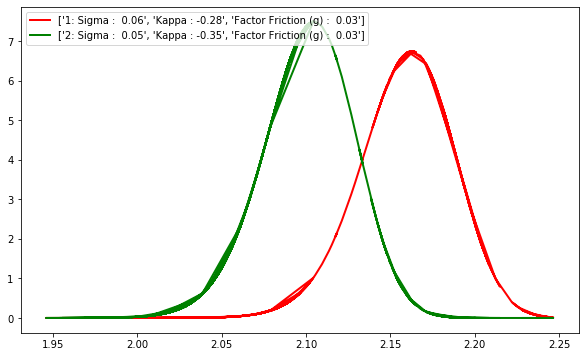

In [15]:
# function that generates values of a normal Probability Density (PDF)

y_t = Data_Model

Log_returns = Data_Model.diff()
asset_log_returns_apple .head()
R_f_real = (asset_log_returns_apple.cumsum())
R_f_real = (R_f_real.mean()).item()



    #Parameters Experiment 1
sigma_exp1 = (sigma.mean()*1).item() #*1 1.45
k_exp1 = (k.mean()*1.2).item()     #*2.1 0.80
g_exp1 = (g.mean()*0.95).item()  #*1
Theta_1= (Theta.mean()*0.85).item() #Theta.mean()
W_z_1 = 0

    
    #Arguments Experiment 1 .item()
R_year_1 = R_f_real 
Z_t = (long_rolling.loc[start_date:end_date, 'log_value']).mean()
Z_t = (Z_t).item()*0
    
Exp_1 = trunc_norm_pdf(y_t,R_year_1, Theta_1 ,sigma_exp1,k_exp1,g_exp1,W_z_1,Z_t)
    
Labels_1 = ['1: Sigma : ' + '{:5.2f}'.format(sigma_exp1),'Kappa : ' + '{:5.2f}'.format(k_exp1),
        'Factor Friction (g) : ' + '{:5.2f}'.format(g_exp1)]

Model_LLE = trunc_norm_pdf(y_t,R_year_1, Theta_1 ,sigma_exp1,k_exp1,g_exp1,W_z_1,Z_t)
Model_LLE_Mean = Model_LLE.mean()

fig9 = plt.figure(figsize=(10,6))
ax9 = fig9.add_subplot(1,1,1)
ax9.plot(y_t, Exp_1,linewidth=2, color='r', label =  Labels_1 )
ax9.legend(loc='upper left')


#Parameters Experiment 2
sigma_exp2 = (sigma.mean()*0.9).item() #*1 1.45  (sigma.mean()*15).item()
k_exp2 = (k.mean()*1.5).item()   #*2.1 0.80
g_exp2 = (g.mean()*1).item()  #*1
Theta_2= (Theta.mean()*.9).item()
W_z_2 = 0

    
    #Arguments Experiment 2
R_year_2 = R_f_real 


Exp_2 = trunc_norm_pdf(y_t,R_year_2, Theta_2 ,sigma_exp2,k_exp1,g_exp2,W_z_2,Z_t)

    
Labels_2 = ['2: Sigma : ' + '{:5.2f}'.format(sigma_exp2),'Kappa : ' + '{:5.2f}'.format(k_exp2),
          'Factor Friction (g) : ' + '{:5.2f}'.format(g_exp2)]




ax9.plot(y_t, Exp_2 ,linewidth=2, color='g', label =  Labels_2 )
ax9.legend(loc='upper left')

print(Model_LLE_Mean)
plt.show()


In [419]:
Exp_2

Date
2014-12-01    6.045095e-01
2014-12-02    5.390057e-01
2014-12-03    7.512592e-01
2014-12-04    6.729637e-01
2014-12-05    5.936730e-01
                  ...     
2017-12-22    5.053819e-09
2017-12-26    2.464429e-07
2017-12-27    2.403927e-07
2017-12-28    1.610924e-07
2017-12-29    7.336261e-07
Name: Adj. Close, Length: 775, dtype: float64

In [423]:
df_Print = pd.DataFrame(Exp_1)
df_Print
df_Print['Adj. Close'] .to_excel("PDF_AAPL.xlsx")

In [53]:
#log likelihood function for the normal distribution
def log_lik_norm(y_t,R_year_crit, Theta_crit ,sigma_crit,k_crit,g_crit,w_crit,Z_crit):
    pdf_vals = trunc_norm_pdf(y_t,R_year_crit, Theta_crit ,sigma_crit,k_crit,g_crit,w_crit,Z_crit)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = (ln_pdf_vals.sum())
    
    return log_lik_val

#print('Log-likelihood 1: ', log_lik_norm(y_t,R_init, Theta_init ,sigma_init,k_init,g_init))
#print('Log-likelihood 2: ', criteria(params_2,R_init)) 

In [55]:
def criteria(param_crit, *OPT):
    R_year_crit2 = R_f_real
    Z_crit       =  Z_t
    Theta_crit ,sigma_crit,k_crit,g_crit,w_crit = param_crit
    y_vals = OPT
    log_lik_val = log_lik_norm(y_vals, R_year_crit2, Theta_crit ,sigma_crit,k_crit,g_crit,w_crit, Z_crit)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [54]:
Z_t

0.0

In [56]:
from scipy.optimize import minimize
# Define The minimize() function and Intial Parameters and Arguments

y_t = Data_Model

sigma_init =(sigma.mean()*1).item() #Limit 0.045 - 0.07,tol = 1e7 L-BFGS-B  (sigma.mean()).item()  
k_init= (k.mean()*0.91).item() #Limit -1.5 - 1 (k.mean()*0.91).item()
g_init= (g.mean()*0.91).item()   #Limit  0.01 - 0.045 (g.mean()*0.91).item() 
Theta_init =(Theta.mean() ).item()#Limit -.7 - + 1*.84    (Theta.mean()).item() 
R_init  = R_f_real  #Constant Value tol = 1e4 , "maxiter" :200
W_init  = 0
params_init = np.array([Theta_init ,sigma_init,k_init,g_init,W_init])
mle_args1= (y_t)


results_cstr = minimize(criteria, params_init, (mle_args1),method="Nelder-Mead", 
                        options={"disp": True, "maxiter" :200, "adaptive": True,'xtol': 1e-8})


Theta_MLE ,sigma_MLE,k_MLE,g_MLE, w_MLE = results_cstr.x
print('Theta_MLE=', Theta_MLE,'sigma_MLE=', sigma_MLE, ' k_MLE =', k_MLE, ' g_MLE =', g_MLE)

print('Log-likelihood 1: ', criteria(params_init,R_init))
results_cstr

Theta_MLE= 0.04794280020949257 sigma_MLE= 0.0017722117725534792  k_MLE = -0.05776919065324182  g_MLE = 0.05878109617608411
Log-likelihood 1:  -3.6908412686979846


 final_simplex: (array([[ 0.0479428 ,  0.00177221, -0.05776919,  0.0587811 ,  0.00287663],
       [ 0.05122699,  0.00157629, -0.05761844,  0.05921358,  0.00286859],
       [ 0.06894863,  0.00316873, -0.05871579,  0.06222727,  0.00271272],
       [ 0.02365411,  0.00291912, -0.05692467,  0.05513766,  0.00292996],
       [ 0.02380714,  0.00440993, -0.05727758,  0.05523961,  0.00286938],
       [ 0.03596873,  0.00477849, -0.05747026,  0.05721673,  0.00280684]]), array([-8269.5541765 , -7341.87484528, -7088.41236936, -7077.3991013 ,
       -6917.32375243, -6698.5035371 ]))
           fun: -8269.55417649687
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 344
           nit: 200
        status: 2
       success: False
             x: array([ 0.0479428 ,  0.00177221, -0.05776919,  0.0587811 ,  0.00287663])

In [57]:
# Verify Init Parameters Values
print((sigma.mean()*1).item())
print((k.mean()*0.91).item())
print((g.mean()*0.91).item() )
print((Theta.mean() ).item())

0.059140096781760784
-0.21505072993038785
0.029305542524535048
-0.130378909890289


## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [69]:
# Put the rest of your code and analysis for Part 2 here.

#Variables, Second Derivative and Quadratic Functions

Theta_R = (Theta_MLE - ((sigma_MLE**2)/2))

K_R = k_MLE**2


Y_a = (np.log(-(-k_MLE-np.sqrt((K_R)+4*g_MLE*Theta_R))/(2*g_MLE)))*-1 # Barrier 1 (Metastable Maximum Value)


print(Y_a)

0.6222421113827937


C:\Users\REFSC\.conda\envs\r-tensorflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


Text(0.5, 0, 'Log Prices (xt)')

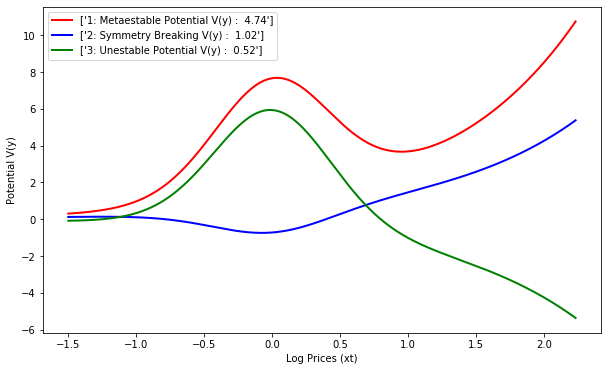

In [115]:
#Evaluation Function Potential V(y)


Oth = pd.DataFrame(np.linspace(-1.5, 2.23, num=Number_Days, endpoint=True) ) 

H_y = (np.cos(Oth))*2.7
R_f1 = Avg_yearly
c_f1 = 0.02
phi_min = sigma_MLE**2 - R_f1 + c_f1
lamda_b = (lamda.mean()).item()
Mu = g_MLE/lamda_b

phi_ant = -lamda_b + np.sqrt(4*g_MLE*phi_min)

phi_max = phi_ant / Mu

Theta_Max = R_f1 - c_f1 - ((sigma_MLE**2)/2) + phi_max

Theta_Min = R_f1 - c_f1 - ((sigma_MLE**2)/2) + phi_min

# Metaestable Potential Experiment 1 

g_Ul1 = 1
k_Ul1 = -20
Theta_Ul1 = 1 # Positive Values

U_l1= ((g_MLE*np.exp(2*H_y)*0.5*g_Ul1) ) + (k_MLE*k_Ul1 *np.exp(Oth))  - ((Theta_Min*Theta_Ul1 -((sigma_MLE**2)/2)).item()*Oth) 

U_l_mean_1 = U_l1.mean()
U_l_mean_T = U_l_mean_1.item()

Labels_Ul1 = ['1: Metaestable Potential V(y) : ' + '{:5.2f}'.format( U_l_mean_T)]

# Symmetry Breaking Experiment 2

g_Ul2 = -.2
k_Ul2 = -10
Theta_Ul2 = -30 # Positive Values

U_l2= ((g_MLE*np.exp(2*H_y)*0.5*g_Ul2) ) + (k_MLE*k_Ul2 *np.exp(Oth))  - ((Theta_Min*Theta_Ul2-((sigma_MLE**2)/2)).item()*Oth)

U_l_mean_2 = U_l2.mean()
U_l_mean_T2 = U_l_mean_2.item()

Labels_Ul2 = ['2: Symmetry Breaking V(y) : ' + '{:5.2f}'.format( U_l_mean_T2)]

# Unestable Potential Experiment 3

g_Ul3 = 1
k_Ul3 = 10
Theta_Ul3 = 1 # Positive Values

U_l3= ((g_MLE*np.exp(2*H_y)*0.5*g_Ul3) ) + (k_MLE*k_Ul3 *np.exp(Oth))  - ((Theta_Min*Theta_Ul3 -((sigma_MLE**2)/2)).item()*Oth) 

U_l_mean_3 = U_l3.mean()
U_l_mean_T3 = U_l_mean_3.item()
Labels_Ul3 = ['3: Unestable Potential V(y) : ' + '{:5.2f}'.format( U_l_mean_T3)]

# Print Experiment

fig10 = plt.figure(figsize=(10,6))
ax10= fig10.add_subplot(1,1,1)
ax10.plot(Oth,U_l1,linewidth=2, color='r', label =  Labels_Ul1 )
ax10.legend(loc='upper left')

ax10.plot(Oth,U_l2,linewidth=2, color='b', label =  Labels_Ul2 )
ax10.legend(loc='upper left')

ax10.plot(Oth,U_l3,linewidth=2, color='g', label =  Labels_Ul3 )
ax10.legend(loc='upper left')
ax10.set_ylabel('Potential V(y)')
ax10.set_xlabel('Log Prices (xt)')
#pl.plot(Oth,U_l2)  
#pl.plot(Oth,U_l1)
#pl.plot(Oth,U_l3)

In [430]:
U_l3.to_excel("UL3_AAPL.xlsx")

In [ ]:
df_Print = pd.DataFrame(Exp_1)
df_Print
df_Print['Adj. Close'] .to_excel("PDF_AAPL.xlsx")

In [150]:
# Analysis Rate Default "Default as an escape from a metastable state"
cf_2 = 0.06
#Theta_Rf = ((R_f1)/100 - cf_2 + (abs(phi_max)/100)

Y_b = ((2*Theta_MLE)/(Y_a*g_MLE*10)) # Barrier 1 (Metastable Minimum Value)

V_b = abs(((g_MLE*np.exp(2*Y_b)*0.5) ) + (k_MLE *np.exp(Y_b))  - ((Theta_Min -((sigma_MLE**2)/2)).item()*Y_b))
V_a = abs(((g_MLE*np.exp(2*Y_a)*0.65) ) + (k_MLE *np.exp(Y_a))  - ((Theta_Min -((sigma_MLE**2)/2)).item()*Y_a))


R1_Term1 = np.sqrt(Y_b)/2*np.pi
R1_Term2 = -(2/(sigma_1.mean()**2))*(V_b-V_a)
R2_Term1 = np.sqrt(Y_a)/2*np.pi

r_kramer_1 = R1_Term1 * np.exp(R1_Term2)
r_kramer_2 = R2_Term1 * np.exp(R1_Term2)


print('Kramers escape rate 1 (r): ' + '{:5.2f}'.format(r_kramer_1.item()) )
print('Kramers escape rate 2 (r): ' + '{:5.2f}'.format(r_kramer_2.item()))

Kramers escape rate 1 (r):  0.63
Kramers escape rate 2 (r):  0.96


## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


2.076369573304125

In [154]:
# Put the rest of your code and analysis for Part 3 here.

# Define The minimize() function and Intial Parameters and Arguments (With Signal SMA for comparing Results)
Z_t = (long_rolling.loc[start_date:end_date, 'log_value']).mean()
Z_t = (Z_t).item()
y_t = Data_Model

sigma_init =(sigma.mean()*1).item() #Limit 0.045 - 0.07,tol = 1e7 L-BFGS-B  (sigma.mean()).item()  
k_init= (k.mean()*0.91).item() #Limit -1.5 - 1 (k.mean()*0.91).item()
g_init= (g.mean()*0.91).item()   #Limit  0.01 - 0.045 (g.mean()*0.91).item() 
Theta_init =(Theta.mean() ).item()#Limit -.7 - + 1*.84    (Theta.mean()).item() 
R_init  = R_f_real  #Constant Value tol = 1e4 , "maxiter" :200
W_init  = 0.1
params_init = np.array([Theta_init ,sigma_init,k_init,g_init,W_init])
mle_args1= (y_t)


results_cstr = minimize(criteria, params_init, (mle_args1),method="Nelder-Mead", 
                        options={"disp": True, "maxiter" :200, "adaptive": True,'xtol': 1e-8})


Theta_MLE ,sigma_MLE,k_MLE,g_MLE, w_MLE = results_cstr.x
print('Theta_MLE=', Theta_MLE,'sigma_MLE=', sigma_MLE, ' k_MLE =', k_MLE, ' g_MLE =', g_MLE, ' W_MLE =', w_MLE)

print('Log-likelihood 1: ', criteria(params_init,R_init))
results_cstr

C:\Users\REFSC\.conda\envs\r-tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Theta_MLE= -0.6502945661015644 sigma_MLE= 0.0034768349606797023  k_MLE = 0.0030040722331686346  g_MLE = -0.008125630233557375  W_MLE = 0.312552708109044
Log-likelihood 1:  11.137944096015854


 final_simplex: (array([[-0.65029457,  0.00347683,  0.00300407, -0.00812563,  0.31255271],
       [-0.65011469,  0.00350786,  0.00296944, -0.00814578,  0.31230603],
       [-0.6507279 ,  0.00336084,  0.00299884, -0.00823602,  0.31236725],
       [-0.64903681,  0.00366997,  0.00290875, -0.00807781,  0.31178733],
       [-0.65025998,  0.00344968,  0.00300895, -0.00819386,  0.31221245],
       [-0.64934576,  0.00359128,  0.00291063, -0.00813783,  0.3117615 ]]), array([-6676.35217158, -6665.25356678, -6654.45508678, -6652.78012146,
       -6650.52886986, -6648.68448852]))
           fun: -6676.352171580398
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 366
           nit: 200
        status: 2
       success: False
             x: array([-0.65029457,  0.00347683,  0.00300407, -0.00812563,  0.31255271])

## Part 1.A: Geometric Brownian Motion Simulation

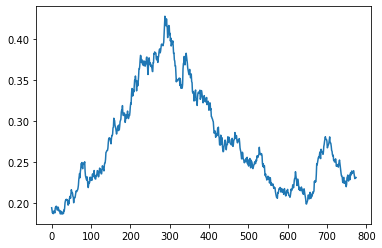

In [314]:
# Put the rest of you code and analysis for Part I here 

# First Step establish Brownian motion function 0, math.sqrt(self.time_period

class GBM:

        
        
    def simulate(self):
        while(self.total_time > 0):
            dS = self.current_price*self.drift*self.time_period + self.current_price*self.volatility*np.random.normal(0, math.sqrt(self.time_period))
            self.prices.append(self.current_price + dS)
            self.current_price += dS
            self.total_time -= self.time_period

    def __init__(self, initial_price, drift, volatility, time_period, total_time):
        self.initial_price = initial_price
        self.current_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.time_period = time_period
        self.total_time = total_time
        self.prices = []
        # Simulate the diffusion process
        self.simulate()   # Simulate the diffusion proces
simulations = []
n = 1
initial_price = min(Data_AAPL['log_value'])/10
drift = .24
volatility = .4 
time_period = 1/Number_Days # Daily
total_time = 1

for i in range(0, n):
    simulations.append(GBM(initial_price, drift, volatility, time_period, total_time))

for sim in simulations:
    plt.plot(np.arange(0, len(sim.prices)), sim.prices)
    
    GBM_Sim = sim.prices
 

plt.show()


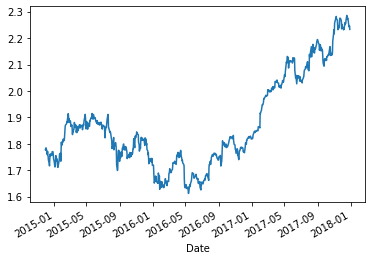

In [213]:
Dv_Dy_Model.plot()

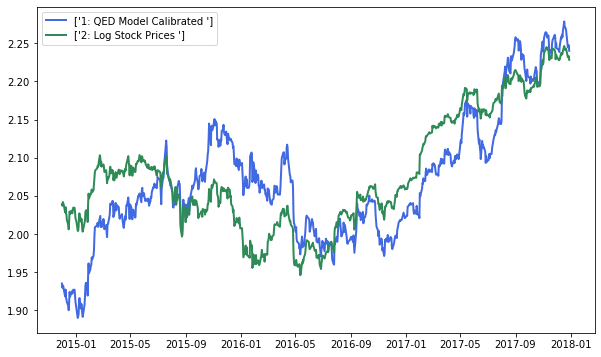

In [351]:
# Analyse the signals SMA 30 days on Model after calibrate + GBM_Sim
Term_M2 = (sigma_MLE**2)/2  

Factor_C = 1.24

Dv_Dy_Model  = -( (Theta_MLE*1.595 - Term_M2 + w_MLE*Z_t*0.138) +k_MLE*np.exp(y_t)+g_MLE*np.exp(2*y_t))*Factor_C

Y_MODEL = Dv_Dy_Model + GBM_Sim

Labels_Model1 = ['1: QED Model Calibrated ']
Labels_Model2 = ['2: Log Stock Prices ']

fig11 = plt.figure(figsize=(10,6))
ax11= fig11.add_subplot(1,1,1)
ax11.plot(Y_MODEL,linewidth=2, color='royalblue', label =  Labels_Model1 )
ax11.plot(y_t,linewidth=2, color='seagreen', label =  Labels_Model2 )

ax11.legend(loc='upper left')
ax.legend(loc='best')

In [435]:
Y_MODEL
df_Print = pd.DataFrame(Y_MODEL)
df_Print
df_Print['Adj. Close'].to_excel("MODEL_QED_AAPL.xlsx")

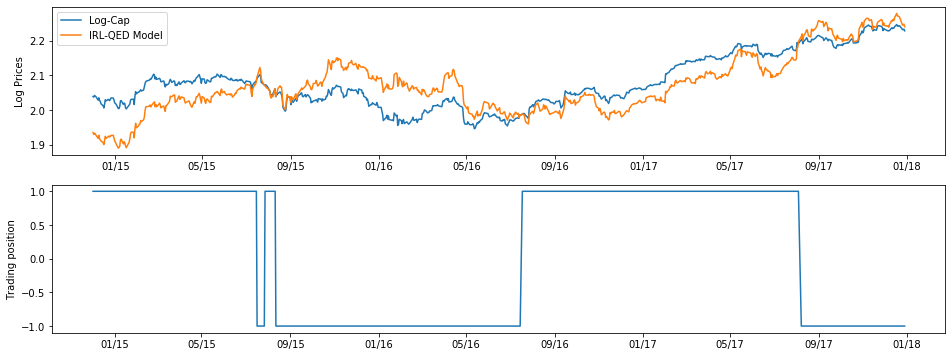

In [352]:
# Trading QED Position & Time Series simulation
QED_Model_1 = pd.DataFrame(Y_MODEL)
QED_Model_1.rename(columns = {'Adj. Close':'log_value'}, inplace = True) 
trading_positions_QED_apple =  apple - QED_Model_1 
trading_positions_QED_apple.tail()
trading_positions_QED_AAPL = trading_positions_QED_apple.apply(np.sign) * 1
trading_Strategy_QED_AAPL = trading_positions_QED_AAPL.shift(1)
trading_Strategy_QED_AAPL.tail()
TRADE_QED_MODEL = trading_Strategy_QED_AAPL.loc[start_date:end_date, 'log_value']
#Trade_SR=trading_positions_final_apple.loc[start_date:end_date, 'log_value']

import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')
fig, (yx9, yx10) = plt.subplots(2, 1, figsize=(16,6))



yx9.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log_value'], label='Log-Cap')
yx9.plot(QED_Model_1.loc[start_date:end_date, :].index, QED_Model_1.loc[start_date:end_date, 'log_value'], label = 'IRL-QED Model')

yx9.set_ylabel('Log Prices')
yx9.legend(loc='best')
yx9.xaxis.set_major_formatter(my_year_month_fmt)

yx10.plot(trading_Strategy_QED_AAPL.loc[start_date:end_date, :].index, trading_Strategy_QED_AAPL.loc[start_date:end_date, 'log_value'], 
        label='Trading position')

yx10.set_ylabel('Trading position')
yx10.xaxis.set_major_formatter(my_year_month_fmt)

In [433]:

df_Print = pd.DataFrame(trading_Strategy_QED_AAPL.loc[start_date:end_date, 'log_value'])
df_Print
df_Print['log_value'].to_excel("ST_QED_AAPL.xlsx")

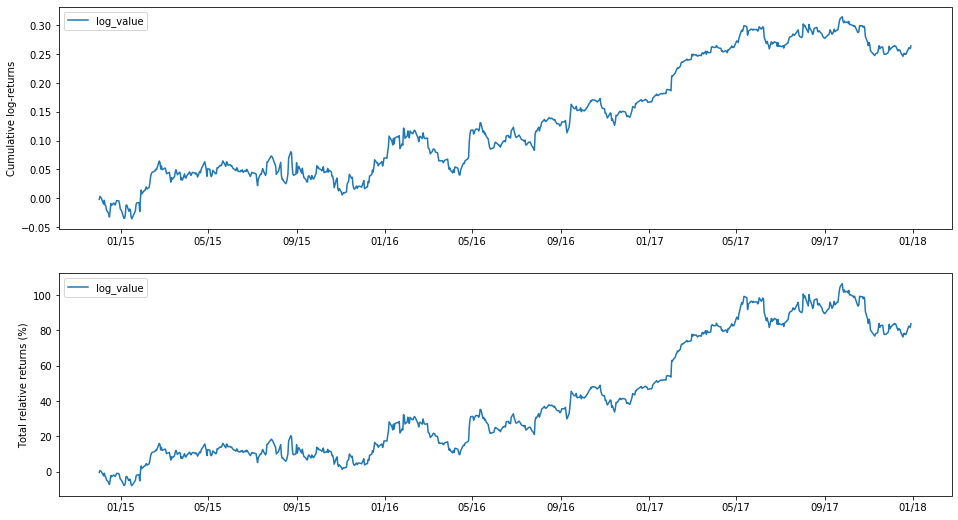

In [353]:
asset_log_returns_apple = apple.diff()
asset_log_returns_apple .head()
strategy_asset_log_returns_QED_apple = asset_log_returns_apple * pd.DataFrame(TRADE_QED_MODEL)
strategy_asset_log_returns_QED_apple.tail()


# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns_QED_apple = strategy_asset_log_returns_QED_apple.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns_QED_apple = 10**(cum_strategy_asset_log_returns_QED_apple) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns_apple:
    ax1.plot(cum_strategy_asset_log_returns_QED_apple.index, cum_strategy_asset_log_returns_QED_apple[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)


for c in asset_log_returns_apple:
    ax2.plot(cum_strategy_asset_relative_returns_QED_apple.index, 100*cum_strategy_asset_relative_returns_QED_apple[c], label=str(c))
    risk_f = 100*cum_strategy_asset_relative_returns_QED_apple[c]
    
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [438]:



df_Print = pd.DataFrame(100*cum_strategy_asset_relative_returns_QED_apple[c])
df_Print
df_Print['log_value'].to_excel("Return_QED_AAPL.xlsx")

In [354]:
#The overall, yearly, performance of our strategy can be calculated again as:
cum_strategy_asset_relative_returns_apple_QED = 10**(cum_strategy_asset_relative_returns_QED_apple) - 1
cum_relative_return_exact_apple_QED = cum_strategy_asset_relative_returns_apple_QED.sum(axis=1)

def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns_apple_long, days_per_year = 52 * 3):

    total_days_in_simulation_long = portfolio_cumulative_relative_returns_apple_long.shape[0]
    number_of_years = total_days_in_simulation_long / days_per_year

    # The last data point will give us the total portfolio return
    
    total_portfolio_return_apple_long = portfolio_cumulative_relative_returns_apple_long[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return_apple_long = (1 + total_portfolio_return_apple_long)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return_apple_long) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return_apple_long) + '%')
    Avg_yearly = 100*average_yearly_return_apple_long
    return Avg_yearly
#print_portfolio_yearly_statistics(cum_relative_return_exact_apple_long)
Avg_yearly_QED=print_portfolio_yearly_statistics(cum_relative_return_exact_apple_QED)

Total portfolio return is: 588.47%
Average yearly return is: 47.45%


## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


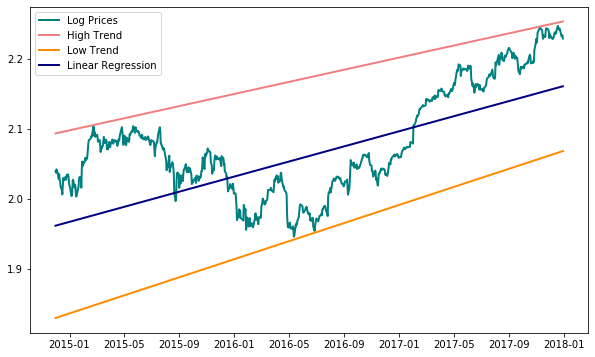

In [16]:


# Put the rest of your code and analysis for Part 3 here.
import pandas as pd
import quandl as qdl
from scipy.stats import linregress

# get AAPL 10 years data

data = qdl.get("WIKI/AAPL", start_date="2014-12-01", end_date="2017-12-31")

Data_AAPL['log10_value'] = np.log10(Data_AAPL['Adj. Close'])
data0 = data.copy()
data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

data0['log10_value'] = np.log10(data0['Adj. Close'])
data0['log10_value_High'] = np.log10(data0['Adj. High'])
data0['log10_value_Low'] = np.log10(data0['Adj. Low'])

# high trend line

data1 = data0.copy()
data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['log10_value_High'],
                    )
    data1 = data1.loc[data1['log10_value_High'] > reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['log10_value_High'],
                    )

data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]

# low trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['log10_value_Low'],
                    )
    data1 = data1.loc[data1['log10_value_Low'] < reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['log10_value_Low'],
                    )

data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]

# plot

Stock_AAPL = pd.DataFrame(data0['log10_value'])

LR_Signal_High = pd.DataFrame(data0['high_trend'])
LR_Signal_Low  = pd.DataFrame(data0['low_trend'])


LR_Signal_High.rename(columns = {'high_trend':'log10_value'}, inplace = True) 
LR_Signal_Low.rename(columns = {'low_trend':'log10_value'}, inplace = True) 

LR_Signal_Reg  = (LR_Signal_High + LR_Signal_Low)/2


fig12 = plt.figure(figsize=(10,6))
ax12= fig12.add_subplot(1,1,1)
ax12.plot(Stock_AAPL,linewidth=2, color='teal', label =  'Log Prices' )
ax12.plot(LR_Signal_High,linewidth=2, color='lightcoral', label =  'High Trend' )
ax12.plot(LR_Signal_Low,linewidth=2, color='darkorange', label =  'Low Trend' )
ax12.plot(LR_Signal_Reg,linewidth=2, color='navy', label =  'Linear Regression' )

ax12.legend(loc='upper left')
ax.legend(loc='best')


In [22]:
LR_Signal_Low['log10_value'].to_excel("HighLow_LR_AAPL.xlsx")

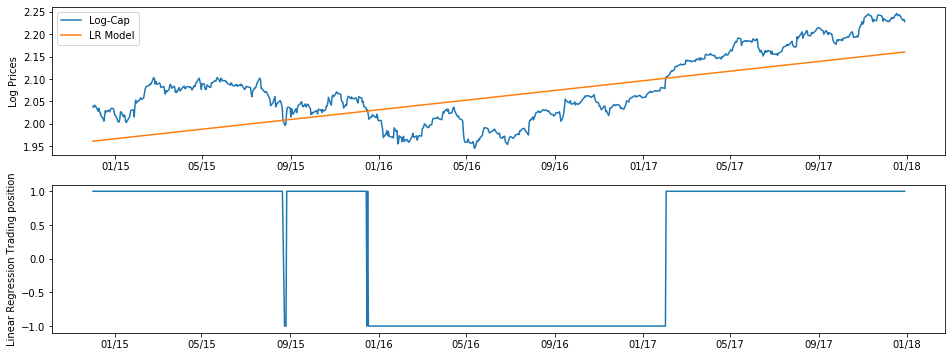

In [29]:
# Trading QED Position & Time Series simulation

trading_positions_LR_apple = Stock_AAPL - LR_Signal_Reg
trading_positions_LR_apple.tail()
trading_positions_LR_AAPL = trading_positions_LR_apple.apply(np.sign) * 1
trading_Strategy_LR_AAPL = trading_positions_LR_AAPL.shift(1)
trading_Strategy_LR_AAPL.tail()
TRADE_LR_MODEL = trading_Strategy_LR_AAPL.loc[start_date:end_date, 'log10_value']
#Trade_SR=trading_positions_final_apple.loc[start_date:end_date, 'log_value']

import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')
fig, (yx13, yx14) = plt.subplots(2, 1, figsize=(16,6))



yx13.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log10_value'], label='Log-Cap')
yx13.plot(LR_Signal_Reg.loc[start_date:end_date, :].index, LR_Signal_Reg.loc[start_date:end_date, 'log10_value'], label = 'LR Model')

yx13.set_ylabel('Log Prices')
yx13.legend(loc='best')
yx13.xaxis.set_major_formatter(my_year_month_fmt)

yx14.plot(trading_Strategy_LR_AAPL.loc[start_date:end_date, :].index, trading_Strategy_LR_AAPL.loc[start_date:end_date, 'log10_value'], 
        label='Linear Regression Trading position')

yx14.set_ylabel('Linear Regression Trading position')
yx14.xaxis.set_major_formatter(my_year_month_fmt)

In [30]:

df_Print = pd.DataFrame(trading_Strategy_LR_AAPL.loc[start_date:end_date, 'log10_value'])
df_Print
df_Print['log10_value'].to_excel("ST_LR_AAPL.xlsx")

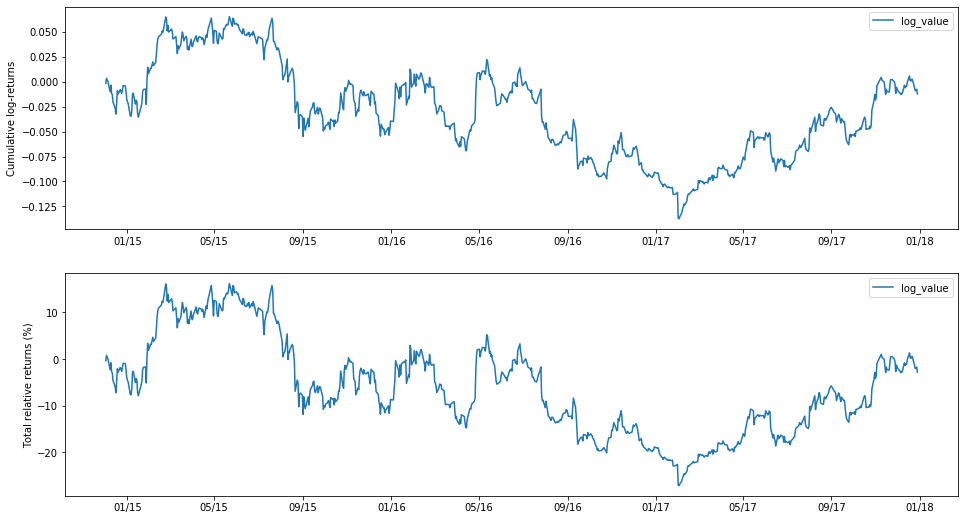

In [31]:
LR_Strategy = pd.DataFrame(TRADE_LR_MODEL)
LR_Strategy.rename(columns = {'log10_value':'log_value'}, inplace = True) 

asset_log_returns_apple = apple.diff()
asset_log_returns_apple .head()
strategy_asset_log_returns_LR_apple = asset_log_returns_apple * LR_Strategy
strategy_asset_log_returns_LR_apple.tail()


# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns_LR_apple = strategy_asset_log_returns_LR_apple.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns_LR_apple = 10**(cum_strategy_asset_log_returns_LR_apple) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns_apple:
    ax1.plot(cum_strategy_asset_log_returns_LR_apple.index, cum_strategy_asset_log_returns_LR_apple[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)


for c in asset_log_returns_apple:
    ax2.plot(cum_strategy_asset_relative_returns_LR_apple.index, 100*cum_strategy_asset_relative_returns_LR_apple[c], label=str(c))
    risk_f = 100*cum_strategy_asset_relative_returns_LR_apple[c]
    
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [32]:
#The overall, yearly, performance of our strategy can be calculated again as:
cum_strategy_asset_relative_returns_apple_LR = 10**(cum_strategy_asset_relative_returns_LR_apple) - 1
cum_relative_return_exact_apple_LR = cum_strategy_asset_relative_returns_apple_LR.sum(axis=1)

def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns_apple_long, days_per_year = 52 * 3):

    total_days_in_simulation_long = portfolio_cumulative_relative_returns_apple_long.shape[0]
    number_of_years = total_days_in_simulation_long / days_per_year

    # The last data point will give us the total portfolio return
    
    total_portfolio_return_apple_long = portfolio_cumulative_relative_returns_apple_long[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return_apple_long = (1 + total_portfolio_return_apple_long)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return_apple_long) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return_apple_long) + '%')
    Avg_yearly = 100*average_yearly_return_apple_long
    return Avg_yearly
#print_portfolio_yearly_statistics(cum_relative_return_exact_apple_long)
Avg_yearly_LR=print_portfolio_yearly_statistics(cum_relative_return_exact_apple_LR)

Total portfolio return is: -6.31%
Average yearly return is: -1.30%


In [35]:

df_Print = pd.DataFrame(100*cum_strategy_asset_relative_returns_LR_apple[c])
df_Print
df_Print['log_value'].to_excel("Return_LR_AAPL.xlsx")

In [3]:
# Analysis in Deep Learning and comparing the results
start_date_train = '2014-12-01'
end_date_train  = '2016-12-31'

dataset_train = pd.DataFrame(Data_AAPL.loc[start_date_train:end_date_train , 'log_value'])
training_set = dataset_train.iloc[:, 0:1].values


In [4]:
X_train = []
y_train = []
for i in range(1, 526):
    X_train.append(training_set[i-1:i, 0])
    y_train.append(training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [6]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 90)

Epoch 1/50
525/525 [==============================] - 3s 5ms/step - loss: 4.0994
Epoch 2/50
525/525 [==============================] - 0s 284us/step - loss: 3.9927
Epoch 3/50
525/525 [==============================] - 0s 270us/step - loss: 3.8552
Epoch 4/50
525/525 [==============================] - 0s 263us/step - loss: 3.6615
Epoch 5/50
525/525 [==============================] - 0s 246us/step - loss: 3.3643
Epoch 6/50
525/525 [==============================] - 0s 255us/step - loss: 2.8829
Epoch 7/50
525/525 [==============================] - 0s 248us/step - loss: 2.0970
Epoch 8/50
525/525 [==============================] - 0s 248us/step - loss: 0.9667
Epoch 9/50
525/525 [==============================] - 0s 248us/step - loss: 0.1587
Epoch 10/50
525/525 [==============================] - 0s 257us/step - loss: 0.3143
Epoch 11/50
525/525 [==============================] - 0s 253us/step - loss: 0.1235
Epoch 12/50
525/525 [==============================] - 0s 248us/step - loss: 0.1033
Epo

In [7]:
#dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
start_date_test = '2017-01-01'
end_date_test = '2017-12-31'

dataset_test = pd.DataFrame(Data_AAPL.loc[start_date_test:end_date_test , 'log_value'])
real_stock_price = dataset_test.iloc[:, 0:1].values

In [81]:
dataset_total = pd.concat((dataset_train['log_value'], dataset_test['log_value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 526:].values
inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)
X_test = []
for i in range(1, 776):
    X_test.append(inputs[i-1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test) + 0.0025
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

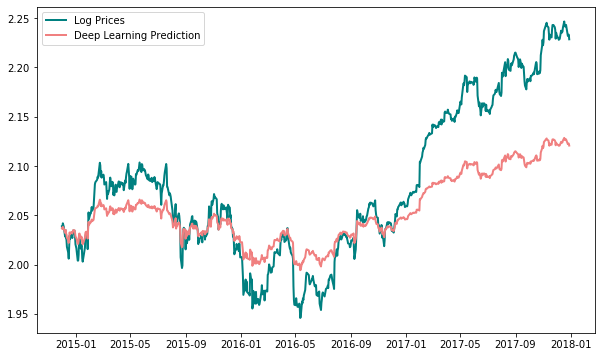

In [82]:
# Keras Long Short-Term Memory (LSTM) Model to Predict Stock Prices
DL_Signal = pd.DataFrame(predicted_stock_price, columns=['Predict Prices']) 

Stock_AAPL = pd.DataFrame(data0['log10_value'])

Stock_AAPL['Predict Prices'] = DL_Signal['Predict Prices'].values



fig15 = plt.figure(figsize=(10,6))
ax15  = fig15.add_subplot(1,1,1)
ax15.plot(Stock_AAPL['log10_value'],linewidth=2, color='teal', label =  'Log Prices' )
ax15.plot(Stock_AAPL['Predict Prices'],linewidth=2, color='lightcoral', label =  'Deep Learning Prediction' )


ax15.legend(loc='upper left')
ax15.legend(loc='best')


In [86]:
df_Print = pd.DataFrame(Stock_AAPL['Predict Prices'])
df_Print
df_Print['Predict Prices'].to_excel("MODEL_DL_AAPL.xlsx")

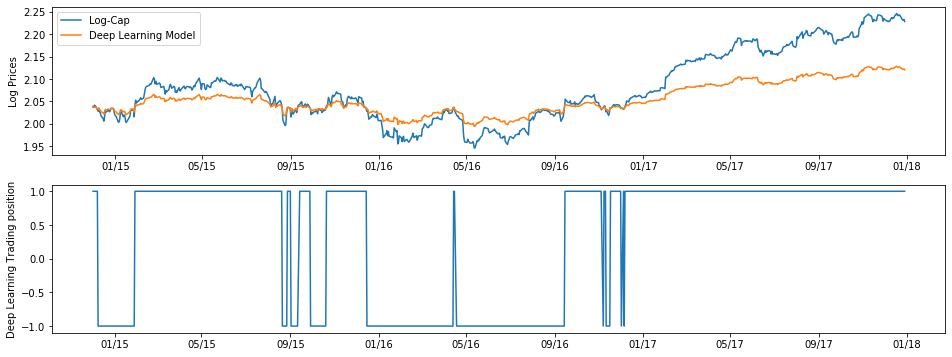

In [83]:
# Trading Deep Learning Position & Time Series simulation
DL_Signal_Model = pd.DataFrame(Stock_AAPL['Predict Prices'])
trading_positions_DL_apple = pd.DataFrame(Stock_AAPL['log10_value']- Stock_AAPL['Predict Prices'], columns=['log10_value'])
trading_positions_DL_apple.tail()
trading_positions_DL_AAPL = trading_positions_DL_apple.apply(np.sign) * 1
trading_Strategy_DL_AAPL = trading_positions_DL_AAPL.shift(1)
trading_Strategy_DL_AAPL.tail()
TRADE_DL_MODEL = trading_Strategy_DL_AAPL.loc[start_date:end_date, 'log10_value']
#Trade_SR=trading_positions_final_apple.loc[start_date:end_date, 'log_value']

import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')
fig, (yx19, yx20) = plt.subplots(2, 1, figsize=(16,6))



yx19.plot(Data_AAPL.loc[start_date:end_date, :].index, Data_AAPL.loc[start_date:end_date, 'log10_value'], label='Log-Cap')
yx19.plot(DL_Signal_Model.loc[start_date:end_date, :].index, DL_Signal_Model.loc[start_date:end_date, 'Predict Prices'], label = 'Deep Learning Model')

yx19.set_ylabel('Log Prices')
yx19.legend(loc='best')
yx19.xaxis.set_major_formatter(my_year_month_fmt)

yx20.plot(trading_Strategy_DL_AAPL.loc[start_date:end_date, :].index, trading_Strategy_DL_AAPL.loc[start_date:end_date, 'log10_value'], 
        label='Deep Learning Trading position')

yx20.set_ylabel('Deep Learning Trading position')
yx20.xaxis.set_major_formatter(my_year_month_fmt)

In [87]:
df_Print = pd.DataFrame(trading_Strategy_DL_AAPL.loc[start_date:end_date, 'log10_value'])
df_Print
df_Print['log10_value'].to_excel("ST_DL_AAPL.xlsx")

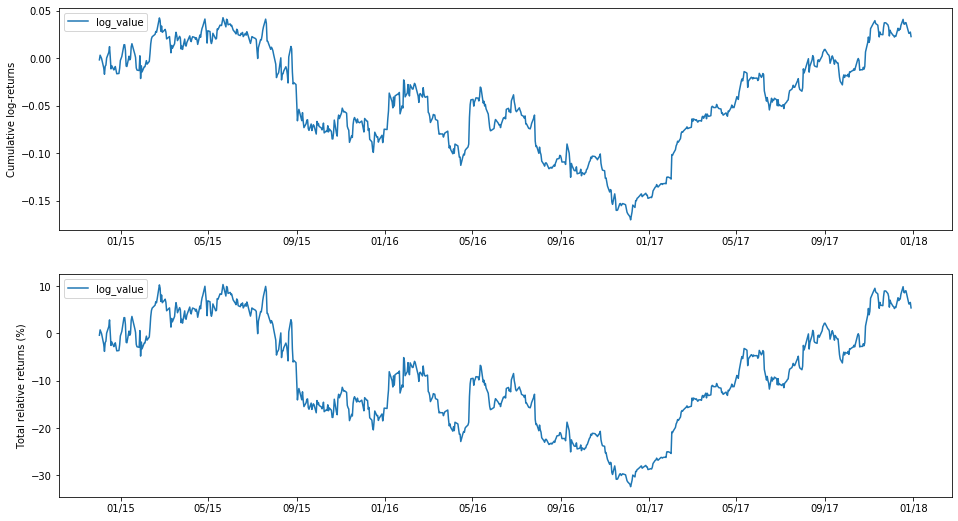

In [84]:

DL_Strategy = pd.DataFrame(trading_Strategy_DL_AAPL)
DL_Strategy.rename(columns = {'log10_value':'log_value'}, inplace = True) 

asset_log_returns_apple = apple.diff()
asset_log_returns_apple .head()
strategy_asset_log_returns_LR_apple = asset_log_returns_apple * DL_Strategy 
strategy_asset_log_returns_LR_apple.tail()


# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns_LR_apple = strategy_asset_log_returns_LR_apple.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns_LR_apple = 10**(cum_strategy_asset_log_returns_LR_apple) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns_apple:
    ax1.plot(cum_strategy_asset_log_returns_LR_apple.index, cum_strategy_asset_log_returns_LR_apple[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)


for c in asset_log_returns_apple:
    ax2.plot(cum_strategy_asset_relative_returns_LR_apple.index, 100*cum_strategy_asset_relative_returns_LR_apple[c], label=str(c))
    risk_f = 100*cum_strategy_asset_relative_returns_LR_apple[c]
    
ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [85]:
#The overall, yearly, performance of our strategy can be calculated again as:
cum_strategy_asset_relative_returns_apple_LR = 10**(cum_strategy_asset_relative_returns_LR_apple) - 1
cum_relative_return_exact_apple_LR = cum_strategy_asset_relative_returns_apple_LR.sum(axis=1)

def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns_apple_long, days_per_year = 52 * 3):

    total_days_in_simulation_long = portfolio_cumulative_relative_returns_apple_long.shape[0]
    number_of_years = total_days_in_simulation_long / days_per_year

    # The last data point will give us the total portfolio return
    
    total_portfolio_return_apple_long = portfolio_cumulative_relative_returns_apple_long[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return_apple_long = (1 + total_portfolio_return_apple_long)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return_apple_long) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return_apple_long) + '%')
    Avg_yearly = 100*average_yearly_return_apple_long
    return Avg_yearly
#print_portfolio_yearly_statistics(cum_relative_return_exact_apple_long)
Avg_yearly_LR=print_portfolio_yearly_statistics(cum_relative_return_exact_apple_LR)

Total portfolio return is: 13.22%
Average yearly return is:  2.53%


In [130]:
100*cum_strategy_asset_relative_returns_LR_apple[c]

Date
2014-12-01          NaN
2014-12-02    -0.382376
2014-12-03    -1.499454
2014-12-04    -1.873303
2014-12-05    -2.289634
                ...    
2017-12-22    13.148243
2017-12-26    10.277674
2017-12-27    10.297070
2017-12-28    10.607402
2017-12-29     9.411332
Name: log_value, Length: 775, dtype: float64

In [90]:
df_Print = pd.DataFrame(100*cum_strategy_asset_relative_returns_LR_apple[c])
df_Print
df_Print['log_value'].to_excel("Return_DL_AAPL.xlsx")